### Подключение библиотек

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, Input
from tensorflow.keras.optimizers import Adam

import sys
import os
sys.path.append(os.path.abspath('..'))
from helpful_functions import train_val_test_split, \
                              create_sequences,\
                              denormalize

## 1. Загрузка данных

In [5]:
file_path = '../dataset/preprocessed_data.csv'
df = pd.read_csv(file_path)

df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)

target_feature = 'Global_active_power'
test_ratio = 0.10
val_ratio = 0.10

train_data, val_data, test_data = train_val_test_split(df, val_ratio, test_ratio)

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

target_idx = df.columns.get_loc(target_feature)
features_count = train_data.shape[1]


## 2. Обучение моделей

In [6]:
learning_rate = 0.001
window_sizes = [10, 30, 60, 90, 120]
results = []

for window_size in window_sizes:
    print(f"\nОбучение RNN с window size = {window_size}")
    
    X_train, y_train = create_sequences(train_scaled, target_idx, window_size)
    X_val, y_val = create_sequences(val_scaled, target_idx, window_size)
    
    rnn_model = Sequential([
        Input(shape=(window_size, features_count)),
        SimpleRNN(50, activation='tanh'),
        Dense(1)
    ])
    rnn_model.compile(optimizer=Adam(learning_rate), loss='mse')
    history_rnn = rnn_model.fit(X_train, y_train,
                                epochs=5,
                                batch_size=256,
                                validation_data=(X_val, y_val))
    
    y_pred_rnn = rnn_model.predict(X_val, verbose=0)
    y_pred_rnn_dn = denormalize(scaler, y_pred_rnn, target_feature, df.columns)
    y_true_val_dn = denormalize(scaler, y_val.reshape(-1, 1), target_feature, df.columns)

    mse_rnn = mean_squared_error(y_true_val_dn, y_pred_rnn_dn)
    
    results.append({
        'model_type': 'RNN',
        'window_size': window_size,
        'train_loss': history_rnn.history['loss'][-1],
        'val_loss': history_rnn.history['val_loss'][-1],
        'mse_dn': mse_rnn
    })
    
    print(f"\nОбучение LSTM с window size = {window_size}")
    
    lstm_model = Sequential([
        Input(shape=(window_size, features_count)),
        LSTM(50, activation='tanh'),
        Dense(1)
    ])
    lstm_model.compile(optimizer=Adam(learning_rate), loss='mse')
    history_lstm = lstm_model.fit(X_train, y_train,
                                  epochs=5,
                                  batch_size=256,
                                  validation_data=(X_val, y_val))
    
    y_pred_lstm = lstm_model.predict(X_val, verbose=0)
    y_pred_lstm_dn = denormalize(scaler, y_pred_lstm, target_feature, df.columns)

    mse_lstm = mean_squared_error(y_true_val_dn, y_pred_lstm_dn)

    results.append({
        'model_type': 'LSTM',
        'window_size': window_size,
        'train_loss': history_lstm.history['loss'][-1],
        'val_loss': history_lstm.history['val_loss'][-1],
        'mse_dn': mse_lstm
    })



Обучение RNN с window size = 10
Epoch 1/5
6486/6486 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0010 - val_loss: 4.0547e-04
Epoch 2/5
6486/6486 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 5.6684e-04 - val_loss: 3.9005e-04
Epoch 3/5
6486/6486 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 5.5264e-04 - val_loss: 3.9153e-04
Epoch 4/5
6486/6486 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 5.4205e-04 - val_loss: 3.8624e-04
Epoch 5/5
6486/6486 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 5.3285e-04 - val_loss: 3.7463e-04

Обучение LSTM с window size = 10
Epoch 1/5
6486/6486 ━━━━━━━━━━━━━━━━━━━━ 46s 7ms/step - loss: 7.9833e-04 - val_loss: 3.8381e-04
Epoch 2/5
6486/6486 ━━━━━━━━━━━━━━━━━━━━ 45s 7ms/step - loss: 5.3678e-04 - val_loss: 3.7987e-04
Epoch 3/5
6486/6486 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step - loss: 5.2272e-04 - val_loss: 3.7097e-04
Epoch 4/5
6486/6486 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 5.1743e-04 - val_loss: 3.6340e-04
Epoch 5/5
6486/6486 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 5.0347e-04 

## 3. Сравнение результатов

In [10]:
results_df = pd.DataFrame(results)
print(results_df.sort_values(by=['mse_dn']))

  model_type  window_size  train_loss  val_loss    mse_dn
7       LSTM           90    0.000485  0.000358  0.043628
3       LSTM           30    0.000492  0.000358  0.043719
9       LSTM          120    0.000495  0.000359  0.043770
5       LSTM           60    0.000494  0.000360  0.043964
1       LSTM           10    0.000503  0.000361  0.044086
8        RNN          120    0.000532  0.000371  0.045211
4        RNN           60    0.000530  0.000372  0.045400
0        RNN           10    0.000532  0.000375  0.045710
2        RNN           30    0.000532  0.000379  0.046275
6        RNN           90    0.000528  0.000384  0.046850


## 4. Построение графиков

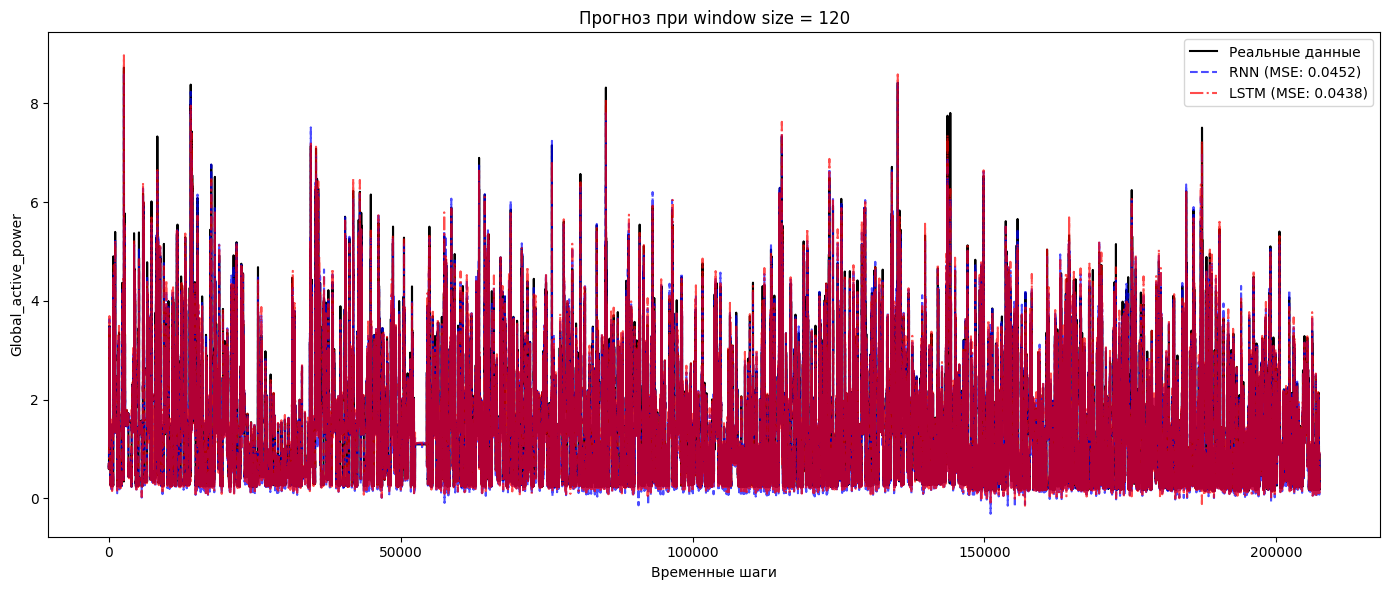

In [8]:
plt.figure(figsize=(14, 6))
plt.plot(y_true_val_dn, label='Реальные данные', color='black')
plt.plot(y_pred_rnn_dn, label=f'RNN (MSE: {mse_rnn:.4f})', linestyle='--', color='blue', alpha=0.7)
plt.plot(y_pred_lstm_dn, label=f'LSTM (MSE: {mse_lstm:.4f})', linestyle='-.', color='red', alpha=0.7)
plt.title(f'Прогноз при window size = {window_size}')
plt.xlabel('Временные шаги')
plt.ylabel('Global_active_power')
plt.legend()
plt.tight_layout()
plt.show()